In [ ]:
!pip install transformers av librosa torchsummary huggingface_hub

# Import necessary libraries
import json
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import av
import numpy as np
import librosa
import matplotlib.pyplot as plt
from transformers import EncodecModel, AutoProcessor, VivitModel, VivitImageProcessor
from huggingface_hub import hf_hub_download
from torchsummary import summary  # For parameters summary, but we'll implement manually
import torch.nn.functional as F
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the JSON data
json_path = "/content/drive/MyDrive/IE_643_Project/train_5000.json"
with open(json_path, "r") as f:
    data = json.load(f)
print(f"Loaded {len(data)} video-audio pairs.")



Using device: cuda
Loaded 5000 video-audio pairs.


In [ ]:
encodec = EncodecModel.from_pretrained("facebook/encodec_24khz").to(device)
audio_processor = AutoProcessor.from_pretrained("facebook/encodec_24khz")

# Freeze the entire audio encoder
for param in encodec.parameters():
    param.requires_grad = False

# Load ViViT model and image processor (video encoder)
model = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400").to(device)
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400", use_fast=True)

# Freeze all layers in ViViT except the 11th layer (index 10, since 0-based)
for param in model.parameters():
    param.requires_grad = False
for name, param in model.named_parameters():
    if "encoder.layer.11" in name:  # 11th layer (0 to 11, 11th is index 10)
        param.requires_grad = True

Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


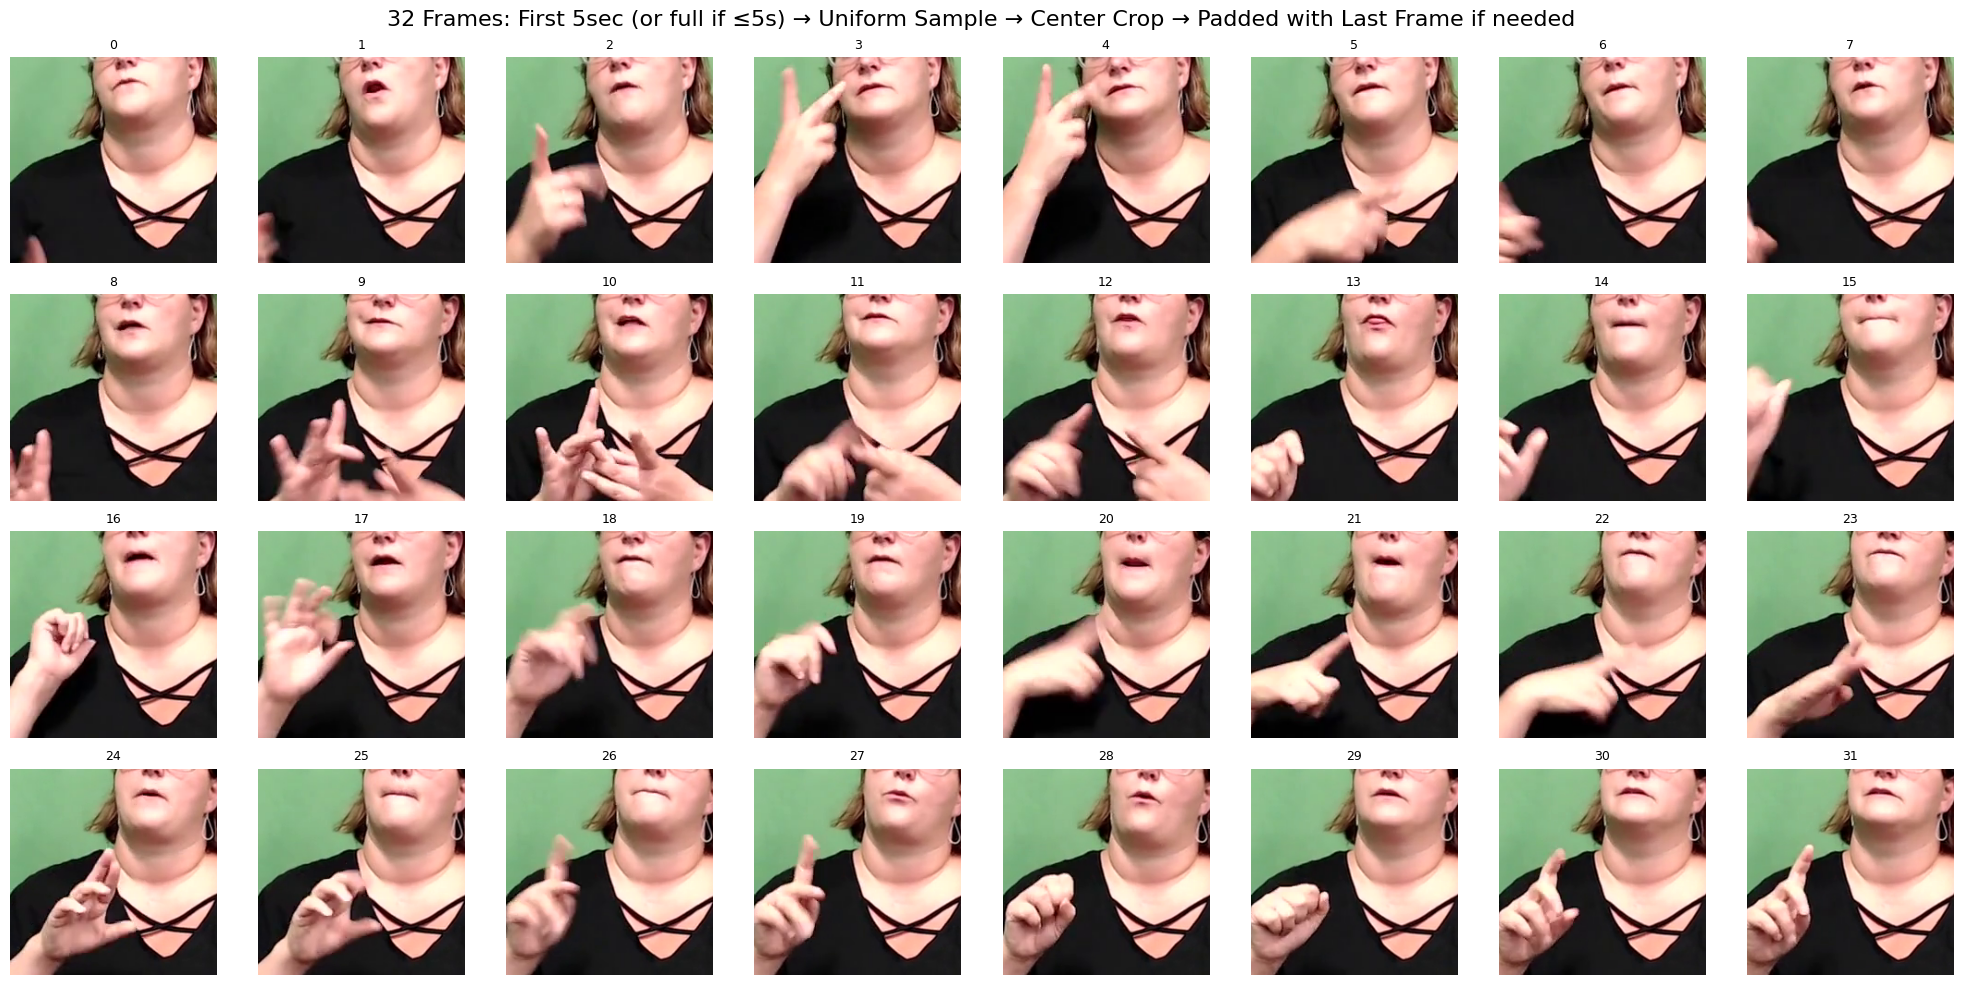


All done! You now have exactly 32 clean frames every time.


In [ ]:
# INSTALL ONCE (if not already installed)
!pip install decord

import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from decord import VideoReader, cpu

# -------------------------------
# Reproducible settings
# -------------------------------
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------
# Your required helper functions (kept as requested)
# -------------------------------
def center_crop_frames(video_array, crop_size=224):
    """video_array: (T, H, W, 3)"""
    T, H, W, _ = video_array.shape
    y1 = (H - crop_size) // 2
    x1 = (W - crop_size) //2
    return video_array[:, y1:y1+crop_size, x1:x1+crop_size, :]

def ensure_fixed_frames(video_array, target_len=32):
    """Force exactly target_len frames: resample if more, pad if less"""
    num_frames = video_array.shape[0]
    if num_frames == target_len:
        return video_array
    elif num_frames > target_len:
        # Uniform downsample
        indices = np.linspace(0, num_frames - 1, target_len).astype(int)
        return video_array[indices]
    else:
        # Pad with last frame
        pad_len = target_len - num_frames
        last_frame = video_array[-1:]  # shape (1, H, W, 3)
        padding = np.repeat(last_frame, pad_len, axis=0)
        return np.concatenate([video_array, padding], axis=0)

# -------------------------------
# MAIN FUNCTION: Exactly what you asked for
# -------------------------------
def get_32_frames_with_padding_and_crop(video_path, max_duration=5.0, target_frames=32, crop_size=224):
    """
    Returns: np.array of shape (32, 224, 224, 3), uint8
    - Uses first 5 seconds (or full if ≤5s)
    - Uniform sampling + padding with last frame if needed
    - Center cropped
    - 100% deterministic
    """
    vr = VideoReader(video_path, ctx=cpu(0))
    fps = vr.get_avg_fps()
    total_frames = len(vr)
    duration_sec = total_frames / fps

    # print(f"Video: {os.path.basename(video_path)}")
    # print(f"   Duration: {duration_sec:.3f}s | FPS: {fps:.2f} | Total frames: {total_frames}")

    # Decide how many frames to consider
    if duration_sec <= max_duration:
        considered_frames = total_frames
        # print(f"   → ≤5s: Using full video ({duration_sec:.2f}s)")
    else:
        considered_frames = int(max_duration * fps)
        # print(f"   → >5s: Trimming to first 5.0s → {considered_frames} frames")

    # Uniformly sample 32 indices from the considered portion
    if considered_frames <= target_frames:
        # Will pad later
        indices = np.arange(considered_frames)
    else:
        indices = np.linspace(0, considered_frames - 1, target_frames).astype(int)

    # Read selected frames
    frames = vr.get_batch(indices.tolist()).asnumpy()  # (N, H, W, 3)

    # Center crop
    frames = center_crop_frames(frames, crop_size=crop_size)

    # Force exactly 32 frames (pad with last frame if needed)
    frames = ensure_fixed_frames(frames, target_len=target_frames)

    # print(f"   Final processed shape: {frames.shape}")
    return frames

# -------------------------------
# TEST ON YOUR VIDEO + VISUALIZATION
# -------------------------------
video_path = "/content/drive/MyDrive/IE_643_Project/train_clips_raw_videos/1TsfCQyFt1A_11-5-rgb_front.mp4"
if not os.path.exists(video_path):
    print("ERROR: Video not found! Check the path.")
else:
    processed_frames = get_32_frames_with_padding_and_crop(video_path)

    # -------------------------------
    # VISUALIZE ALL 32 FRAMES
    # -------------------------------
    plt.figure(figsize=(20, 10))
    for i in range(32):
        plt.subplot(4, 8, i + 1)
        plt.imshow(processed_frames[i])
        plt.title(f"{i}", fontsize=9)
        plt.axis("off")
    plt.suptitle(
        "32 Frames: First 5sec (or full if ≤5s) → Uniform Sample → Center Crop → Padded with Last Frame if needed",
        fontsize=16, y=0.98
    )
    plt.tight_layout()
    plt.show()

    print("\nAll done! You now have exactly 32 clean frames every time.")

In [ ]:
processed_frames.shape

(32, 224, 224, 3)

Adapter parameters: 411521
Optimizer rebuilt with adapter parameters.

==================== Epoch 1/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `VivitImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Similarity matrix (first batch):


Batches:  17%|█▋        | 1/6 [00:07<00:36,  7.39s/it]

[[ 2.4371922e+00  6.9448292e-02  2.8631556e+00  2.8773248e+00
   2.3225319e+00  7.9738557e-01  2.0359876e+00  1.7663809e+00
   3.0522277e+00  1.2768487e+00  2.9662836e+00  2.8780627e+00
   2.1816661e+00  3.1155026e+00  7.5514019e-01  2.4804065e+00]
 [ 2.3863685e+00  1.7590578e-01  2.7693882e+00  2.7410383e+00
   2.2853525e+00  8.2643712e-01  1.9650838e+00  1.6810193e+00
   2.9887669e+00  1.2942348e+00  2.8840129e+00  2.8042619e+00
   2.1302083e+00  3.0407648e+00  6.7239207e-01  2.5402741e+00]
 [ 2.4531469e+00  3.2202959e-02  2.8911738e+00  2.9249425e+00
   2.3279560e+00  7.6641124e-01  2.0565779e+00  1.7983030e+00
   3.0665109e+00  1.2789290e+00  3.0030313e+00  2.9014933e+00
   2.1904845e+00  3.1378529e+00  7.9204303e-01  2.4500837e+00]
 [ 2.4079874e+00  1.0694668e-01  2.8159933e+00  2.8135312e+00
   2.3009424e+00  8.0109167e-01  2.0003080e+00  1.7243059e+00
   3.0207608e+00  1.2735258e+00  2.9325535e+00  2.8452213e+00
   2.1468167e+00  3.0728869e+00  7.1319509e-01  2.5011945e+00]
 [ 2

Batches:  33%|███▎      | 2/6 [00:47<01:46, 26.60s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [01:30<01:42, 34.03s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [02:17<01:18, 39.03s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [02:58<00:40, 40.02s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [03:43<00:00, 37.26s/it]


Epoch 1/20 | Loss: 2.900584

==================== Epoch 2/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:36,  7.26s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.18s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.07s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.15s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:35<00:07,  7.11s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:42<00:00,  7.14s/it]


Epoch 2/20 | Loss: 2.763237

==================== Epoch 3/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:36,  7.40s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.18s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.14s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.21s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:35<00:07,  7.17s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:43<00:00,  7.20s/it]


Epoch 3/20 | Loss: 2.744407

==================== Epoch 4/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:36,  7.36s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.20s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.10s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.19s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:35<00:07,  7.14s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:43<00:00,  7.18s/it]


Epoch 4/20 | Loss: 2.665506

==================== Epoch 5/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:37,  7.43s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.24s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.14s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.20s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:35<00:07,  7.16s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:43<00:00,  7.21s/it]


Epoch 5/20 | Loss: 2.537957

==================== Epoch 6/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:36,  7.37s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.23s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.15s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.22s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:36<00:07,  7.19s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:43<00:00,  7.21s/it]


Epoch 6/20 | Loss: 2.489943

==================== Epoch 7/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:37,  7.42s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.23s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.13s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.18s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:35<00:07,  7.15s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:43<00:00,  7.19s/it]


Epoch 7/20 | Loss: 2.474895

==================== Epoch 8/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:36,  7.36s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.23s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.14s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.20s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:35<00:07,  7.15s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:43<00:00,  7.19s/it]


Epoch 8/20 | Loss: 2.462613

==================== Epoch 9/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:37,  7.43s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.23s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.13s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.20s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:35<00:07,  7.16s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:43<00:00,  7.20s/it]


Epoch 9/20 | Loss: 2.449032

==================== Epoch 10/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:36,  7.38s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.21s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.11s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.21s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:35<00:07,  7.18s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:43<00:00,  7.21s/it]


Epoch 10/20 | Loss: 2.465561

==================== Epoch 11/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:37,  7.41s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.23s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.10s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.21s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:35<00:07,  7.16s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:43<00:00,  7.20s/it]


Epoch 11/20 | Loss: 2.467805

==================== Epoch 12/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:36,  7.35s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.19s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.12s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.20s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:35<00:07,  7.17s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:43<00:00,  7.20s/it]


Epoch 12/20 | Loss: 2.427924

==================== Epoch 13/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:37,  7.43s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.24s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.13s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.22s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:36<00:07,  7.19s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:43<00:00,  7.23s/it]


Epoch 13/20 | Loss: 2.422635

==================== Epoch 14/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:36,  7.37s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.21s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.13s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.21s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:35<00:07,  7.19s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:43<00:00,  7.21s/it]


Epoch 14/20 | Loss: 2.417234

==================== Epoch 15/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:36,  7.38s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.23s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.11s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.22s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:35<00:07,  7.18s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:43<00:00,  7.21s/it]


Epoch 15/20 | Loss: 2.411488

==================== Epoch 16/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:36,  7.38s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.20s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.13s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.22s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:35<00:07,  7.18s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:43<00:00,  7.20s/it]


Epoch 16/20 | Loss: 2.408038

==================== Epoch 17/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:36,  7.36s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.22s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.12s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.26s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:36<00:07,  7.21s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:43<00:00,  7.23s/it]


Epoch 17/20 | Loss: 2.405879

==================== Epoch 18/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:36,  7.34s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.21s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.14s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.22s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:35<00:07,  7.18s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:43<00:00,  7.21s/it]


Epoch 18/20 | Loss: 2.404901

==================== Epoch 19/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:37,  7.41s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.24s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.13s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.20s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:35<00:07,  7.16s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:43<00:00,  7.19s/it]


Epoch 19/20 | Loss: 2.402896

==================== Epoch 20/20 ====================


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 0EjXICFqrKo_9-8-rgb_front.mp4
   Duration: 0.800s | FPS: 30.00 | Total frames: 24
   → ≤5s: Using full video (0.80s)
Video: 1TsfCQyFt1A_11-5-rgb_front.mp4
   Duration: 5.167s | FPS: 24.00 | Total frames: 124
   → >5s: Trimming to first 5.0s → 120 frames
Video: 1Tix6cnQko4_3-5-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: FWxpecaJ2mA_13-5-rgb_front.mp4
   Duration: 2.958s | FPS: 24.00 | Total frames: 71
   → ≤5s: Using full video (2.96s)
Video: 1mrUTikYY-c_7-11-rgb_front.mp4
   Duration: 4.458s | FPS: 24.00 | Total frames: 107
   → ≤5s: Using full video (4.46s)
Video: c5SLsQzzdF4_6-3-rgb_front.mp4
   Duration: 6.708s | FPS: 24.00 | Total frames: 161
   → >5s: Trimming to first 5.0s → 120 frames
Video: -1fUFbij2s0_1-5-rgb_front.mp4
   Duration: 13.680s | FPS: 23.98 | Total frames: 328
   → >5s: Tr

Batches:  17%|█▋        | 1/6 [00:07<00:37,  7.42s/it]

Video: 4QhpU9Fk5dA_2-8-rgb_front.mp4
   Duration: 5.339s | FPS: 23.98 | Total frames: 128
   → >5s: Trimming to first 5.0s → 119 frames
Video: 18PiUlfjLEQ_17-2-rgb_front.mp4
   Duration: 4.958s | FPS: 24.00 | Total frames: 119
   → ≤5s: Using full video (4.96s)
Video: Fii1YOmjEwQ_15-9-rgb_front.mp4
   Duration: 1.083s | FPS: 24.00 | Total frames: 26
   → ≤5s: Using full video (1.08s)
Video: B_e7YfBqy_s_15-5-rgb_front.mp4
   Duration: 1.250s | FPS: 24.00 | Total frames: 30
   → ≤5s: Using full video (1.25s)
Video: 1WGejpkD8ns_11-5-rgb_front.mp4
   Duration: 7.000s | FPS: 24.00 | Total frames: 168
   → >5s: Trimming to first 5.0s → 120 frames
Video: aAbdm-MtiSw_3-3-rgb_front.mp4
   Duration: 5.667s | FPS: 24.00 | Total frames: 136
   → >5s: Trimming to first 5.0s → 120 frames
Video: -916rCqIrfY_20-5-rgb_front.mp4
   Duration: 6.542s | FPS: 24.00 | Total frames: 157
   → >5s: Trimming to first 5.0s → 120 frames
Video: aKsbJ8peDKQ_2-8-rgb_front.mp4
   Duration: 3.292s | FPS: 24.00 | Total 

Batches:  33%|███▎      | 2/6 [00:14<00:28,  7.24s/it]

Video: 1-VX310yQTw_23-1-rgb_front.mp4
   Duration: 7.500s | FPS: 24.00 | Total frames: 180
   → >5s: Trimming to first 5.0s → 120 frames
Video: 0zD5Uh7S35A_4-5-rgb_front.mp4
   Duration: 1.792s | FPS: 24.00 | Total frames: 43
   → ≤5s: Using full video (1.79s)
Video: eXgUJuEhrY0_4-5-rgb_front.mp4
   Duration: 4.500s | FPS: 24.00 | Total frames: 108
   → ≤5s: Using full video (4.50s)
Video: cmFd-YkgJ0w_14-9-rgb_front.mp4
   Duration: 2.542s | FPS: 24.00 | Total frames: 61
   → ≤5s: Using full video (2.54s)
Video: 1joPNyRKT78_14-8-rgb_front.mp4
   Duration: 1.917s | FPS: 24.00 | Total frames: 46
   → ≤5s: Using full video (1.92s)
Video: 1yFEO-of5B0_11-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)
Video: 1cDoGd8wPfw_8-5-rgb_front.mp4
   Duration: 2.458s | FPS: 24.00 | Total frames: 59
   → ≤5s: Using full video (2.46s)
Video: 14weIYQswlE_30-8-rgb_front.mp4
   Duration: 0.167s | FPS: 24.00 | Total frames: 4
   → ≤5s: Using full video

Batches:  50%|█████     | 3/6 [00:21<00:21,  7.14s/it]

Video: 5Pm9nRXM-L0_6-8-rgb_front.mp4
   Duration: 3.712s | FPS: 23.98 | Total frames: 89
   → ≤5s: Using full video (3.71s)
Video: 14PatN6qnsQ_6-8-rgb_front.mp4
   Duration: 1.708s | FPS: 24.00 | Total frames: 41
   → ≤5s: Using full video (1.71s)
Video: 0C_NjyLtHwc_67_68_69-8-rgb_front.mp4
   Duration: 9.083s | FPS: 24.00 | Total frames: 218
   → >5s: Trimming to first 5.0s → 120 frames
Video: bVR-LN22vWk_12-8-rgb_front.mp4
   Duration: 3.083s | FPS: 24.00 | Total frames: 74
   → ≤5s: Using full video (3.08s)
Video: 49P4e1DLm6w_4-5-rgb_front.mp4
   Duration: 4.625s | FPS: 24.00 | Total frames: 111
   → ≤5s: Using full video (4.62s)
Video: -0yRaqY7nTE_3-5-rgb_front.mp4
   Duration: 4.796s | FPS: 23.98 | Total frames: 115
   → ≤5s: Using full video (4.80s)
Video: 14klV5a4_Rg_8-8-rgb_front.mp4
   Duration: 4.583s | FPS: 24.00 | Total frames: 110
   → ≤5s: Using full video (4.58s)
Video: 0EjXICFqrKo_6-8-rgb_front.mp4
   Duration: 1.767s | FPS: 30.00 | Total frames: 53
   → ≤5s: Using full

Batches:  67%|██████▋   | 4/6 [00:28<00:14,  7.23s/it]

Video: -fC91WQRXio_6-3-rgb_front.mp4
   Duration: 10.625s | FPS: 24.00 | Total frames: 255
   → >5s: Trimming to first 5.0s → 120 frames
Video: e9UWZ3kkA7Y_6-8-rgb_front.mp4
   Duration: 2.333s | FPS: 24.00 | Total frames: 56
   → ≤5s: Using full video (2.33s)
Video: bP8YvikdELg_8-5-rgb_front.mp4
   Duration: 3.417s | FPS: 24.00 | Total frames: 82
   → ≤5s: Using full video (3.42s)
Video: aNME-T1NzK8_8-8-rgb_front.mp4
   Duration: 2.500s | FPS: 24.00 | Total frames: 60
   → ≤5s: Using full video (2.50s)
Video: 18NasCihOMs_14-8-rgb_front.mp4
   Duration: 1.042s | FPS: 24.00 | Total frames: 25
   → ≤5s: Using full video (1.04s)
Video: 1joPNyRKT78_8-8-rgb_front.mp4
   Duration: 2.292s | FPS: 24.00 | Total frames: 55
   → ≤5s: Using full video (2.29s)
Video: 4Mi3E9RcS_o_10-8-rgb_front.mp4
   Duration: 4.250s | FPS: 24.00 | Total frames: 102
   → ≤5s: Using full video (4.25s)
Video: 16n946j6kpM_7-8-rgb_front.mp4
   Duration: 0.667s | FPS: 24.00 | Total frames: 16
   → ≤5s: Using full video 

Batches:  83%|████████▎ | 5/6 [00:36<00:07,  7.18s/it]

Video: 0EjXICFqrKo_47-8-rgb_front.mp4
   Duration: 1.733s | FPS: 30.00 | Total frames: 52
   → ≤5s: Using full video (1.73s)
Video: FJwlsdc-urQ_18-8-rgb_front.mp4
   Duration: 4.375s | FPS: 24.00 | Total frames: 105
   → ≤5s: Using full video (4.38s)
Video: 0xxbsy0Ek9I_11-5-rgb_front.mp4
   Duration: 5.208s | FPS: 24.00 | Total frames: 125
   → >5s: Trimming to first 5.0s → 120 frames
Video: ah-PM4tolJ4_20-5-rgb_front.mp4
   Duration: 1.208s | FPS: 24.00 | Total frames: 29
   → ≤5s: Using full video (1.21s)
Video: -8tIt1vEinQ_9-8-rgb_front.mp4
   Duration: 0.792s | FPS: 24.00 | Total frames: 19
   → ≤5s: Using full video (0.79s)
Video: 02WRxAwx-Bo_23-8-rgb_front.mp4
   Duration: 3.167s | FPS: 24.00 | Total frames: 76
   → ≤5s: Using full video (3.17s)
Video: 0Fs8a5vglXc_1-8-rgb_front.mp4
   Duration: 4.000s | FPS: 24.00 | Total frames: 96
   → ≤5s: Using full video (4.00s)
Video: 1qNsErmkIiU_6-3-rgb_front.mp4
   Duration: 4.167s | FPS: 24.00 | Total frames: 100
   → ≤5s: Using full vid

Batches: 100%|██████████| 6/6 [00:43<00:00,  7.21s/it]

Epoch 20/20 | Loss: 2.401456


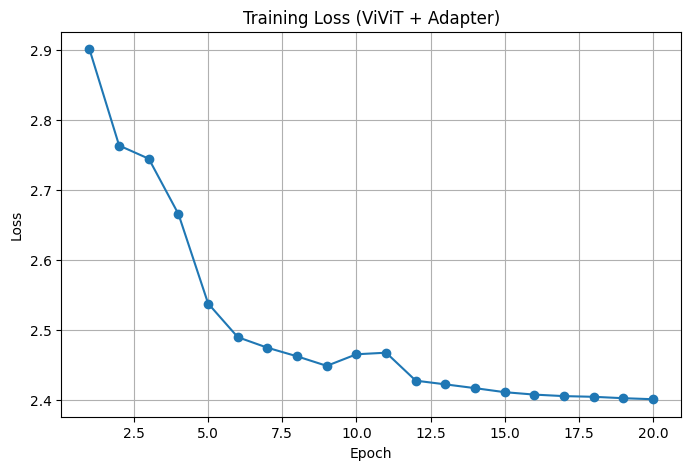

In [ ]:
# ================================================================
#  VIDEO → AUDIO ADAPTER (APPROACH 2: CROSS-ATTENTION)
#  Fully Pasteable Google Colab Block
# ================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import chain
from itertools import chain
import torch.optim.lr_scheduler as lr_scheduler
num_epochs   = 20
batch_size   = 16
max_duration = 10          # seconds
sr           = 24000
tau          = 0.07
lam1         = 1.0
lam2         = 0.0
selected_pairs = data[:100]

# --------------------------------------------------------------
#  Positional Encoding (sinusoidal)
# --------------------------------------------------------------
class TimePositionalEncoding(nn.Module):
    def __init__(self, dim, max_len=3000):
        super().__init__()
        pe = torch.zeros(max_len, dim)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        pe[:, 0::2] = torch.sin(pos * inv_freq)
        pe[:, 1::2] = torch.cos(pos * inv_freq)
        self.register_buffer('pe', pe)

    def forward(self, idxs):
        return self.pe[idxs]  # (T, D)


# --------------------------------------------------------------
#  Video → Audio Adapter (Approach 2: Cross-Attention)
# --------------------------------------------------------------
class VideoToAudioAdapter(nn.Module):
    def __init__(self, t_video=16, t_audio=750, d_vid=768, d_audio=128, n_heads=8):
        super().__init__()
        self.t_video = t_video
        self.t_audio = t_audio

        # Soft spatial attention-pooling over 196 patches
        self.pool_score = nn.Linear(d_vid, 1)

        # Projection into audio-token space
        self.frame_proj = nn.Linear(d_vid, d_audio)
        self.cls_proj   = nn.Linear(d_vid, d_audio)

        # Audio queries from positional encodings
        self.audio_query_mlp = nn.Sequential(
            nn.Linear(d_audio, d_audio),
            nn.GELU(),
            nn.Linear(d_audio, d_audio)
        )

        # Cross attention
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=d_audio,
            num_heads=n_heads,
            batch_first=True
        )

        # Post-smoothing
        self.smoother = nn.Conv1d(
            in_channels=d_audio,
            out_channels=d_audio,
            kernel_size=7,
            padding=3
        )

        self.pos_enc = TimePositionalEncoding(d_audio, max_len=3000)

    def forward(self, last_hidden_states):
        """
        Input:  (B, 3137, 768)  from ViViT
        Output: (B, 750, 128)
        """
        B = last_hidden_states.size(0)
        device = last_hidden_states.device

        # ---------- Split CLS + patches ----------
        cls = last_hidden_states[:, 0, :]         # (B,768)
        patches = last_hidden_states[:, 1:, :]    # (B,3136,768)

        # ---------- reshape patches ----------
        patches = patches.view(B, self.t_video, 196, 768)  # (B,16,196,768)

        # ---------- spatial pooling ----------
        scores = self.pool_score(patches).squeeze(-1)      # (B,16,196)
        weights = torch.softmax(scores, dim=-1)
        frame_feats = torch.einsum('bfp,bfpd->bfd', weights, patches)  # (B,16,768)

        # ---------- project to audio embedding ----------
        frame_kv = self.frame_proj(frame_feats)          # (B,16,128)
        cls_kv   = self.cls_proj(cls).unsqueeze(1)       # (B,1,128)
        kv = torch.cat([frame_kv, cls_kv], dim=1)        # (B,17,128)

        # ---------- build audio queries ----------
        t_idxs = torch.arange(0, self.t_audio, device=device)
        pos = self.pos_enc(t_idxs)                       # (750,128)
        q   = pos.unsqueeze(0).expand(B, -1, -1)         # (B,750,128)
        queries = self.audio_query_mlp(q)                # (B,750,128)

        # ---------- Cross Attention ----------
        attn_out, _ = self.cross_attn(query=queries, key=kv, value=kv)

        # ---------- Temporal Smoothing ----------
        smooth = self.smoother(attn_out.transpose(1,2)).transpose(1,2)

        return smooth  # (B,750,128)



# ================================================================
#  INSTANTIATE ADAPTER *BEFORE* TRAINING LOOP
# ================================================================
video_adapter = VideoToAudioAdapter(
    t_video=16,
    t_audio=750,
    d_vid=768,
    d_audio=128,
    n_heads=8
).to(device)

print("Adapter parameters:", sum(p.numel() for p in video_adapter.parameters()))


# ================================================================
#  MODIFY TRAINABLE PARAMS (include adapter)
# ================================================================
trainable_params = [
    p for p in chain(model.parameters(), video_adapter.parameters())
    if p.requires_grad
]

optimizer = optim.Adam(trainable_params, lr=3e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print("Optimizer rebuilt with adapter parameters.")



# ================================================================
#  TRAINING LOOP (UNCHANGED EXCEPT 1 LINE)
# ================================================================
losses = []
similarity_matrix_printed = False

for epoch in range(num_epochs):
    num_batches = len(selected_pairs) // batch_size
    epoch_loss  = 0.0
    print(f"\n{'='*20} Epoch {epoch+1}/{num_epochs} {'='*20}")

    for batch_idx in tqdm(range(num_batches), desc="Batches"):
        batch = selected_pairs[batch_idx*batch_size : (batch_idx+1)*batch_size]

        # ----------------------------------------------------------
        #  AUDIO PROCESSING: SAME AS YOUR CODE
        # ----------------------------------------------------------
        wavs = []
        for item in batch:
            wav, _ = librosa.load(item["audio_path"], sr=sr, mono=True)
            target_len = sr * max_duration
            if len(wav) > target_len:
                wav = wav[:target_len]
            else:
                wav = np.pad(wav, (0, target_len - len(wav)), "constant")
            wavs.append(wav)

        audio_inputs = audio_processor(raw_audio=wavs,
                                       sampling_rate=sr,
                                       return_tensors="pt")
        input_values = audio_inputs["input_values"].to(device)

        with torch.no_grad():
            encoder_output = encodec.encoder(input_values).permute(0, 2, 1)
        audio_feats = encoder_output.mean(dim=1)
        audio_proj = audio_feats / torch.norm(audio_feats, dim=1, keepdim=True).clamp(min=1e-6)


        # ----------------------------------------------------------
        #  VIDEO PROCESSING: SAME AS YOUR CODE
        # ----------------------------------------------------------
        videos = []
        for item in batch:
            video_path = item["video_path"]
            if not os.path.exists(video_path):
              print("ERROR: Video not found! Check the path.")
            else:
              vid = get_32_frames_with_padding_and_crop(video_path)
            # seg_len   = container.streams.video[0].frames
            # idx       = sample_frame_indices(clip_len=32, frame_sample_rate=1, seg_len=seg_len)
            # vid       = read_video_pyav(container, idx)
            # vid       = ensure_fixed_frames(vid, 32)
            # vid       = center_crop_frames(vid, crop_size=224)
            videos.append(vid.astype(np.uint8))

        videos_as_lists = [[f for f in v] for v in videos]
        inputs = image_processor(videos_as_lists,
                                 return_tensors="pt",
                                 data_format="channels_first",
                                 padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # ----------- ViViT forward (unchanged) -------------------
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state   # (B,3137,768)


        # ----------------------------------------------------------
        #  *** REPLACEMENT: OUR NEW ADAPTER ***
        # ----------------------------------------------------------
        video_fcc = video_adapter(last_hidden_states)        # (B,750,128)

        # Flatten + L2-normalize
        video_proj = video_fcc.mean(dim=1)
        video_proj = video_proj / torch.norm(video_proj, dim=1, keepdim=True).clamp(min=1e-6)


        # ----------------------------------------------------------
        #  CONTRASTIVE LOSS  (same)
        # ----------------------------------------------------------
        # sim = (audio_proj @ video_proj.T) / tau
        # labels = torch.arange(batch_size, device=device)

        # loss_a2v = F.cross_entropy(sim, labels)
        # loss_v2a = F.cross_entropy(sim.T, labels)
        # loss1 = (loss_a2v + loss_v2a) / 2

        logits = (audio_proj @ video_proj.T) / tau

        labels = torch.arange(batch_size, device=device)
        loss = (F.cross_entropy(logits, labels, label_smoothing=0.1) +
                    F.cross_entropy(logits.T, labels, label_smoothing=0.1)) / 2
        # _, mse_like = compute_metrics(encoder_output, video_fcc)
        # loss2 = mse_like.mean(dim=0)

        # loss = lam1 * loss1
        epoch_loss += loss.item()


        # ----------------------------------------------------------
        #  BACKPROP (same)
        # ----------------------------------------------------------
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)
        optimizer.step()


        if epoch == 0 and batch_idx == 0 and not similarity_matrix_printed:
            print("\nSimilarity matrix (first batch):")
            print(logits.detach().cpu().numpy())
            similarity_matrix_printed = True


    # ----------------------------------------------------------
    #  EPOCH SUMMARY (same)
    # ----------------------------------------------------------
    avg_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.6f}")
    losses.append(avg_loss)
    scheduler.step()


# --------------------------------------------------------------
#  PLOT LOSS CURVE  (same)
# --------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (ViViT + Adapter)')
plt.grid(True)
plt.show()


Using device: cuda
Adapter parameters: 39355008
Optimizer rebuilt with adapter parameters.

==================== Epoch 1/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]


Similarity matrix (first batch):
[[3.1426136 3.091663  3.4255667 3.1304586 3.161363  3.019088  3.300894
  3.2602422 3.1644812 3.1585045 3.009308  3.088908  3.0283856 3.274043
  2.988877  2.9061596]
 [3.024392  2.9682722 3.34268   3.0556786 3.0694926 2.9336572 3.2239132
  3.182653  3.091264  3.0408292 2.9266415 2.978152  2.8865392 3.215076
  2.8786309 2.7838604]
 [3.1817746 3.128889  3.446029  3.1476817 3.1864703 3.0467124 3.3185964
  3.282516  3.1794732 3.1953301 3.0320354 3.1219072 3.0749717 3.2862566
  3.0209684 2.94041  ]
 [3.076415  3.0241344 3.3738978 3.0809865 3.104291  2.968598  3.2499225
  3.209014  3.1146588 3.0896037 2.9558327 3.0222158 2.9551377 3.2272344
  2.9231086 2.8351057]
 [2.974404  2.9191217 3.308417  3.0248425 3.032785  2.9017708 3.1935194
  3.1511316 3.0638044 2.9920373 2.8940227 2.932728  2.830268  3.1886497
  2.833963  2.7348294]
 [3.2441676 3.1968977 3.489358  3.191468  3.2355852 3.0868022 3.3593106
  3.3295274 3.225553  3.2543573 3.0765712 3.1835692 3.1487157 

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2/45 | Loss: 2.627563

==================== Epoch 3/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3/45 | Loss: 2.549318

==================== Epoch 4/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4/45 | Loss: 2.530556

==================== Epoch 5/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5/45 | Loss: 2.488392

==================== Epoch 6/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6/45 | Loss: 2.478276

==================== Epoch 7/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7/45 | Loss: 2.455361

==================== Epoch 8/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8/45 | Loss: 2.447887

==================== Epoch 9/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9/45 | Loss: 2.419570

==================== Epoch 10/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10/45 | Loss: 2.403226

==================== Epoch 11/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11/45 | Loss: 2.399312

==================== Epoch 12/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12/45 | Loss: 2.385373

==================== Epoch 13/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13/45 | Loss: 2.380714

==================== Epoch 14/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14/45 | Loss: 2.378140

==================== Epoch 15/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15/45 | Loss: 2.376674

==================== Epoch 16/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16/45 | Loss: 2.375459

==================== Epoch 17/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17/45 | Loss: 2.374355

==================== Epoch 18/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18/45 | Loss: 2.373376

==================== Epoch 19/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19/45 | Loss: 2.372523

==================== Epoch 20/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20/45 | Loss: 2.371770

==================== Epoch 21/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 21/45 | Loss: 2.370696

==================== Epoch 22/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 22/45 | Loss: 2.370554

==================== Epoch 23/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 23/45 | Loss: 2.370481

==================== Epoch 24/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 24/45 | Loss: 2.370419

==================== Epoch 25/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 25/45 | Loss: 2.370359

==================== Epoch 26/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 26/45 | Loss: 2.370298

==================== Epoch 27/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 27/45 | Loss: 2.370236

==================== Epoch 28/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 28/45 | Loss: 2.370175

==================== Epoch 29/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 29/45 | Loss: 2.370112

==================== Epoch 30/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 30/45 | Loss: 2.370050

==================== Epoch 31/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 31/45 | Loss: 2.369954

==================== Epoch 32/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 32/45 | Loss: 2.369948

==================== Epoch 33/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 33/45 | Loss: 2.369942

==================== Epoch 34/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 34/45 | Loss: 2.369935

==================== Epoch 35/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 35/45 | Loss: 2.369928

==================== Epoch 36/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 36/45 | Loss: 2.369922

==================== Epoch 37/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 37/45 | Loss: 2.369915

==================== Epoch 38/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 38/45 | Loss: 2.369908

==================== Epoch 39/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 39/45 | Loss: 2.369901

==================== Epoch 40/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 40/45 | Loss: 2.369894

==================== Epoch 41/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 41/45 | Loss: 2.369883

==================== Epoch 42/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 42/45 | Loss: 2.369883

==================== Epoch 43/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 43/45 | Loss: 2.369882

==================== Epoch 44/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 44/45 | Loss: 2.369881

==================== Epoch 45/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 45/45 | Loss: 2.369881


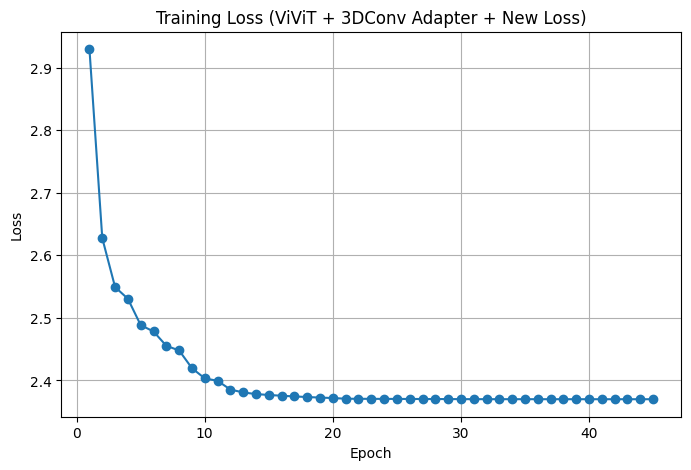

In [ ]:
# ================================================================
#  VIDEO → AUDIO ADAPTER (3D CONV VERSION YOU REQUESTED)
#  Fully Pasteable Google Colab Block
# ================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import chain
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import librosa
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
num_epochs   = 45
batch_size   = 16
max_duration = 10
sr           = 24000
base_tau     = 0.07
lam1         = 1.0
selected_pairs = data[:400]  # <-- YOUR DATA

# ------------------- DEVICE ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# ================================================================
# 3D CONV VIDEO → AUDIO ADAPTER
# ================================================================
class VideoConv3DAdapter(nn.Module):
    """
    Input:  (B, 3136, 768)   → remove CLS → reshape → (B,16,14,14,768)
    Output: (B, 750, 128)
    """
    def __init__(self):
        super().__init__()

        # Spatial collapse: 14×14 → 1×1
        self.spatial_conv = nn.Conv3d(
            in_channels=768,
            out_channels=256,
            kernel_size=(1, 14, 14),
            stride=(1, 14, 14)
        )

        # Temporal upsampling 16 → 150
        self.temporal_up1 = nn.ConvTranspose3d(
            in_channels=256,
            out_channels=256,
            kernel_size=(10,1,1),
            stride=(10,1,1)
        )

        # Temporal upsampling 150 → 750
        self.temporal_up2 = nn.ConvTranspose3d(
            in_channels=256,
            out_channels=128,
            kernel_size=(5,1,1),
            stride=(5,1,1)
        )

    def forward(self, last_hidden_states):
        """
        last_hidden_states: (B, 3137, 768)
        Remove CLS → (B, 3136, 768)
        Reshape → (B, 16, 14, 14, 768)
        """
        B = last_hidden_states.size(0)

        patches = last_hidden_states[:, 1:, :]        # (B, 3136, 768)
        patches = patches.view(B, 16, 14, 14, 768)    # (B,16,14,14,768)

        # Change ordering for Conv3D: (B, C, D, H, W)
        x = patches.permute(0, 4, 1, 2, 3).contiguous()  # (B,768,16,14,14)

        x = self.spatial_conv(x)   # (B,256,16,1,1)
        x = self.temporal_up1(x)   # (B,256,150,1,1)
        x = self.temporal_up2(x)   # (B,128,750,1,1)

        # Remove spatial dim
        x = x.squeeze(-1).squeeze(-1)    # (B,128,750)

        return x.permute(0,2,1)          # (B,750,128)



# ================================================================
# Instantiate adapter BEFORE training loop
# ================================================================
video_adapter = VideoConv3DAdapter().to(device)
print("Adapter parameters:", sum(p.numel() for p in video_adapter.parameters()))


# ================================================================
# Modify trainable parameters (ViViT + Adapter)
# ================================================================
trainable_params = [
    p for p in chain(model.parameters(), video_adapter.parameters())
    if p.requires_grad
]

optimizer = torch.optim.Adam(trainable_params, lr=3e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
print("Optimizer rebuilt with adapter parameters.")


# ================================================================
# *** NEW CONTRASTIVE LOSS YOU ASKED FOR ***
#
# video_fcc: (B,750,128)
# audio_fcc: (B,750,128)
#
# Step 1: element-wise dot over 128 dims → (B,750)
# Step 2: avg over time → (B,128)
#
# NO prior pooling before dot
# ================================================================
# def new_clip_similarity(video_fcc, audio_fcc, tau=0.07):
#     """
#     video_fcc: (B,750,128)
#     audio_fcc: (B,750,128)
#     """
#     # element-wise product
#     prod = video_fcc * audio_fcc             # (B,750,128)

#     # average over time → (B,128)
#     pooled = prod.mean(dim=1)                # (B,128)

#     # L2 normalization
#     pooled = pooled / (pooled.norm(dim=1, keepdim=True) + 1e-6)

#     return pooled   # return final embeddings for contrastive loss



# ================================================================
# TRAINING LOOP (MODIFIED)
# ================================================================
losses = []
similarity_matrix_printed = False
num_epochs = 45
batch_size = 16
tau = 0.07

for epoch in range(num_epochs):
    num_batches = len(selected_pairs) // batch_size
    epoch_loss  = 0.0
    print(f"\n{'='*20} Epoch {epoch+1}/{num_epochs} {'='*20}")

    for batch_idx in tqdm(range(num_batches), desc="Batches"):
        batch = selected_pairs[batch_idx*batch_size : (batch_idx+1)*batch_size]

        # ----------------------------------------------------------
        #  AUDIO PROCESSING (same as your code)
        # ----------------------------------------------------------
        wavs = []
        for item in batch:
            wav, _ = librosa.load(item["audio_path"], sr=24000, mono=True)
            target_len = sr * max_duration
            if len(wav) > target_len:
                wav = wav[:target_len]
            else:
                wav = np.pad(wav, (0, target_len - len(wav)), "constant")
            wavs.append(wav)

        audio_inputs = audio_processor(raw_audio=wavs,
                                       sampling_rate=sr,
                                       return_tensors="pt")

        input_values = audio_inputs["input_values"].to(device)

        with torch.no_grad():
            encoder_output = encodec.encoder(input_values).permute(0, 2, 1)  # (B,C,T)

        # audio representation per timestep (match video shape!)
        audio_fcc = encoder_output.mean(dim=1)  # (B,T,C)

        # normalize channels
        # audio_fcc = audio_fcc[:, :750, :]          # ensure length matches
        audio_proj = audio_fcc / (audio_fcc.norm(dim=-1, keepdim=True) + 1e-6)



        # ----------------------------------------------------------
        #  VIDEO PROCESSING (same as your pipeline)
        # ----------------------------------------------------------
        videos = []
        for item in batch:
            video_path = item["video_path"]
            vid = get_32_frames_with_padding_and_crop(video_path)
            videos.append(vid.astype(np.uint8))

        videos_as_lists = [[f for f in v] for v in videos]
        inputs = image_processor(videos_as_lists,
                                 return_tensors="pt",
                                 data_format="channels_first",
                                 padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}


        # ViViT forward
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state   # (B,3137,768)

        # ----------------------------------------------------------
        #   OUR NEW 3D-CONV ADAPTER (Approach C hybrid)
        # ----------------------------------------------------------
        video_fcc = video_adapter(last_hidden_states)  # (B,750,128)
        video_fcc = video_fcc.mean(dim=1)             # (B,128)
        video_proj = video_fcc / (video_fcc.norm(dim=-1, keepdim=True) + 1e-6)



        # ==========================================================
        # *** NEW CONTRASTIVE LOSS EXACTLY AS YOU REQUESTED ***
        # ==========================================================
        logits = (audio_proj @ video_proj.T) / tau

        labels = torch.arange(batch_size, device=device)
        loss = (F.cross_entropy(logits, labels, label_smoothing=0.1) +
                    F.cross_entropy(logits.T, labels, label_smoothing=0.1)) / 2
        # _, mse_like = compute_metrics(encoder_output, video_fcc)
        # loss2 = mse_like.mean(dim=0)

        # loss = lam1 * loss1
        epoch_loss += loss.item()


        # ----------------------------------------------------------
        #  BACKPROP
        # ----------------------------------------------------------
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(trainable_params, 1.0)
        optimizer.step()


        if epoch == 0 and batch_idx == 0 and not similarity_matrix_printed:
            print("\nSimilarity matrix (first batch):")
            print(logits.detach().cpu().numpy())
            similarity_matrix_printed = True


    # ----------------------------------------------------------
    #  EPOCH SUMMARY
    # ----------------------------------------------------------
    avg_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.6f}")
    losses.append(avg_loss)
    scheduler.step()



# ================================================================
#  PLOT LOSS CURVE
# ================================================================
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (ViViT + 3DConv Adapter + New Loss)')
plt.grid(True)
plt.show()


In [ ]:
def video_to_waveform(video_path, model, video_adapter, encodec, image_processor, device):
    """Video → (750, 128) → Encodec codes (for reconstruction)"""
    model.eval()
    video_adapter.eval()        # ← This is the correct module
    with torch.no_grad():
        # Load and preprocess 32 frames (your custom function)
        vid = get_32_frames_with_padding_and_crop(video_path)

        # Preprocess with image processor (same as training)
        inputs = image_processor([[f for f in vid]], return_tensors="pt",
                                 data_format="channels_first", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Forward through ViViT backbone
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state  # (1, 3137, 768)

        # → NEW: Use the cross-attention adapter instead of linear proj
        vid_emb = video_adapter(last_hidden_states)     # (1, 750, 128)

        # Prepare codes for Encodec decoder: (B, 128, 750)
        codes = vid_emb.permute(0, 2, 1)                # (1, 128, 750)

        return codes  # You can later decode with: encodec.decoder(codes)

In [ ]:
codes = video_to_waveform(
    video_path="/content/drive/MyDrive/IE_643_Project/train_clips_raw_videos/1YAa5_d-zg0_10-8-rgb_front.mp4",
    model=model,
    video_adapter=video_adapter,   # ← pass the adapter module, not a tensor
    encodec=encodec,
    image_processor=image_processor,
    device=device
)

Video: 1YAa5_d-zg0_10-8-rgb_front.mp4
   Duration: 3.458s | FPS: 24.00 | Total frames: 83
   → ≤5s: Using full video (3.46s)


In [ ]:
codes


tensor([[[-2.0186e-01, -3.6918e-01, -5.6965e-01,  ..., -1.4744e+00,
          -1.2999e+00, -1.0636e+00],
         [ 1.8678e-02,  7.5110e-02,  3.9955e-02,  ...,  3.3574e-01,
           2.7745e-01,  3.0173e-01],
         [ 1.5605e-01,  2.2857e-01,  1.9684e-01,  ...,  2.4712e-01,
          -2.5486e-02,  7.5704e-04],
         ...,
         [-1.2342e-01, -1.1341e-01, -1.4283e-01,  ..., -1.6041e-01,
          -2.3107e-02, -2.1030e-03],
         [ 9.2561e-02,  2.8801e-02, -9.0066e-02,  ...,  1.5907e-01,
           1.9085e-01,  8.4477e-02],
         [ 3.3795e-01,  2.5024e-01,  3.1150e-01,  ...,  7.3678e-03,
          -6.9870e-02, -7.5302e-02]]], device='cuda:0')

In [ ]:
x=encodec.quantizer.encode(codes, bandwidth=1.5)
x = x.permute(1, 0, 2)
x = x.unsqueeze(0)
x.shape

torch.Size([1, 1, 2, 750])

In [ ]:
import soundfile as sf
with torch.no_grad():
    decoded = encodec.decode(x,audio_scales=[None])

# -------------------------------
# Extract and save reconstructed audio
# -------------------------------
if isinstance(decoded, (tuple, list)):
    audio = decoded[0].squeeze().cpu().numpy()

else:
    audio = decoded.audio_values.squeeze().cpu().numpy()
    # print("Decoded audio shape:", audio.shape)

# Ensure audio is mono float32
if audio.ndim > 1:
    audio = audio[0]
audio = audio.astype(np.float32)

# Write file
sf.write('test_reconstructed.wav', audio, samplerate=24000)
print("✅ Wrote test_reconstructed.wav — play to verify.")
# embeddings = encodec.quantizer.decode(encoder_outputs.audio_codes.squeeze(0))
# print(embeddings)

✅ Wrote test_reconstructed.wav — play to verify.
